<a href="https://colab.research.google.com/github/MysteriousLin6/QNN_XOR/blob/main/XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install pennylane pennylane-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 37.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 138.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [pennylane]


Initial theta: [3.44829694 4.49366732 3.78727399 3.42360201]
Initial loss: 0.3776607050312301
Step   1 | Loss = 0.377661
Step  20 | Loss = 0.005073
Step  40 | Loss = 0.001153
Step  60 | Loss = 0.000491
Step  80 | Loss = 0.000270
Step 100 | Loss = 0.000170
Step 120 | Loss = 0.000117
Step 140 | Loss = 0.000085
Step 160 | Loss = 0.000065
Step 180 | Loss = 0.000051
Step 200 | Loss = 0.000041
Final loss: 4.059174879661198e-05
Trained theta (rad): [3.19229016 6.13156815 3.78727399 3.14209276]
theta_1 = 3.192290 rad  = 182.90 deg
theta_2 = 6.131568 rad  = 351.31 deg
theta_3 = 3.787274 rad  = 216.99 deg
theta_4 = 3.142093 rad  = 180.03 deg

Predictions:
Input [0 0] | target = 0.0 | model p(1) = 0.0064
Input [0 1] | target = 1.0 | model p(1) = 0.9936
Input [1 0] | target = 1.0 | model p(1) = 0.9937
Input [1 1] | target = 0.0 | model p(1) = 0.0063


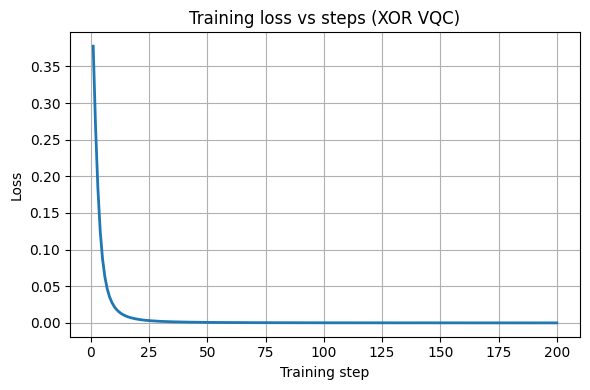

In [40]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
!pip install "jax~=0.6.0" "jaxlib~=0.6.0" -q

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def xor_circuit(x, theta):
    if x[0] == 1:
        qml.PauliX(0)
    if x[1] == 1:
        qml.PauliX(1)

    qml.RY(theta[0], wires=0)
    qml.RY(theta[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(theta[2], wires=0)
    qml.RY(theta[3], wires=1)

    return qml.probs(wires=1)

# Data
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
Y = np.array([0., 1., 1., 0.])

# Fix the random seed for reproducibility.
np.random.seed(0)

# Initialization parameters (trainable)
theta = np.random.uniform(0, 2*np.pi, 4)
theta = np.array(theta, requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.4)

def cost(theta):
    loss = 0
    for x, y in zip(X, Y):
        probs = xor_circuit(x, theta)
        p1 = probs[1]
        loss += (p1 - y) ** 2
    return loss / len(X)

# Training + Recording loss
num_steps = 200
loss_history = []   # Be sure to clear it here

print("Initial theta:", theta)
print("Initial loss:", cost(theta))

for step in range(1, num_steps + 1):
    theta, loss = opt.step_and_cost(cost, theta)
    loss_history.append(loss)
    if step == 1 or step % 20 == 0:
        print(f"Step {step:3d} | Loss = {loss:.6f}")


print("Final loss:", cost(theta))

print("Trained theta (rad):", theta)

for i, val in enumerate(theta):
    print(f"theta_{i+1} = {float(val):.6f} rad  "
          f"= {float(val)*180/np.pi:.2f} deg")

print("\nPredictions:")
for x, y in zip(X, Y):
    probs = xor_circuit(x, theta)
    p1 = probs[1]
    print(f"Input {x} | target = {y:.1f} | model p(1) = {p1:.4f}")

# Convergence curve
plt.figure(figsize=(6,4))
plt.plot(range(1, num_steps + 1), loss_history, linewidth=2)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training loss vs steps (XOR VQC)")
plt.grid(True)
plt.tight_layout()
plt.show()